In [1]:
import torch
# The autograd package provides automatic differentiation 
# for all operations on Tensors

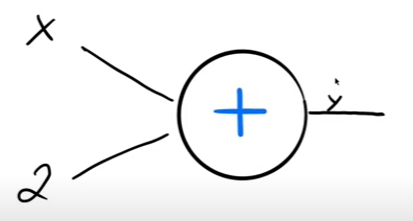

Pytorch will create a computation graph if we specify `requires_grad=True` 

In [2]:
# requires_grad = True -> tracks all operations on the tensor. 
x = torch.randn(3, requires_grad=True)
y = x + 2

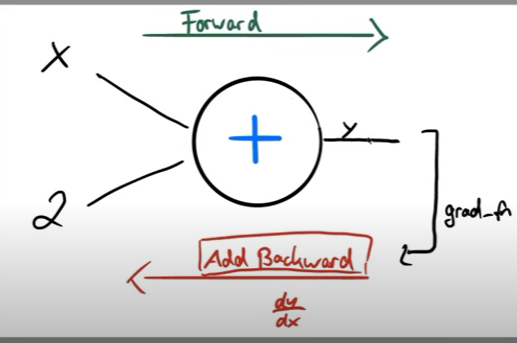

In [3]:
# y was created as a result of an operation, so it has a grad_fn attribute.
# grad_fn: references a Function that has created the Tensor
print(x) # created by the user -> grad_fn is None
print(y)
print(y.grad_fn)

tensor([-0.4246, -1.2319, -0.9513], requires_grad=True)
tensor([1.5754, 0.7681, 1.0487], grad_fn=<AddBackward0>)


In [4]:
# Do more operations on y
z = y * y * 3
print(z)
z = z.mean()
print(z)

tensor([7.4461, 1.7698, 3.2992], grad_fn=<MulBackward0>)
tensor(4.1717, grad_fn=<MeanBackward0>)


In [5]:
# Let's compute the gradients with backpropagation
# When we finish our computation we can call .backward() and have all the gradients computed automatically.
# The gradient for this tensor will be accumulated into .grad attribute.
# It is the partial derivate of the function w.r.t. the tensor

z.backward(retain_graph=True)
print(x.grad) # dz/dx

# Generally speaking, torch.autograd is an engine for computing vector-Jacobian product
# It computes partial derivates while applying the chain rule


tensor([3.1509, 1.5362, 2.0974])


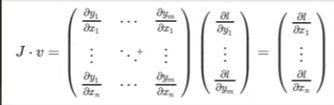

J Stand for Jacobian matrix which is a matrix of all partial derivatives of the output of the network with respect to the input of the network
 
v is the vector of the gradient of the loss function with respect to the output of the network

The gradient of the loss function with respect to the input of the network is the dot product of the Jacobian matrix and the gradient of the loss function with respect to the output of the network



In [6]:
# Model with non-scalar output:
# If a Tensor is non-scalar (more than 1 elements), we need to specify arguments for backward() 
# specify a gradient argument that is a tensor of matching shape.
# needed for vector-Jacobian product

x = torch.randn(3, requires_grad=True)

y = x * 2
for _ in range(10):
    y = y * 2

print(y)
print(y.shape)

v = torch.tensor([0.1, 1.0, 0.0001], dtype=torch.float32)
y.backward(v)
print(x.grad)

tensor([-654.8083, 1348.9191, 1798.6783], grad_fn=<MulBackward0>)
torch.Size([3])
tensor([2.0480e+02, 2.0480e+03, 2.0480e-01])


In [7]:
# Stop a tensor from tracking history:
# For example during our training loop when we want to update our weights
# then this update operation should not be part of the gradient computation
# - x.requires_grad_(False) -> in-place change
# - x.detach() -> get a new Tensor with the same content but does not require gradients
# - wrap in 'with torch.no_grad():'

In [8]:
# .requires_grad_(...) changes an existing flag in-place.
a = torch.randn(2, 2)
print(a.requires_grad)

b = ((a * 3) / (a - 1))
print(b.grad_fn)

a.requires_grad_(True)
print(a.requires_grad)

b = (a * a).sum()
print(b.grad_fn)

a.requires_grad_(False)
print(a.requires_grad)


False
None
True
False


In [9]:
# .detach(): get a new Tensor with the same content but no gradient computation:
a = torch.randn(2, 2, requires_grad=True)
print(a.requires_grad)

b = a.detach()
print(b.requires_grad)


True
False


In [10]:
# wrap in 'with torch.no_grad():'
a = torch.randn(2, 2, requires_grad=True)
print(a.requires_grad)
with torch.no_grad():
    print((x ** 2).requires_grad)

True
False


In [11]:
# backward() accumulates the gradient for this tensor into .grad attribute.
# !!! We need to be careful during optimization !!!
# Use .zero_() to empty the gradients before a new optimization step!
weights = torch.ones(4, requires_grad=True)
print(weights)

for epoch in range(3):
    # just a dummy example
    model_output = (weights*31).sum()
    model_output.backward()
    
    print(weights.grad)

tensor([1., 1., 1., 1.], requires_grad=True)
tensor([31., 31., 31., 31.])
tensor([62., 62., 62., 62.])
tensor([93., 93., 93., 93.])


In [12]:
weights = torch.ones(4, requires_grad=True)

for epoch in range(3):
    # just a dummy example
    model_output = (weights*3).sum()
    model_output.backward()
    
    print(weights.grad)

    # this is important! It affects the final weights & output
    weights.grad.zero_()

print(weights)

tensor([3., 3., 3., 3.])
tensor([3., 3., 3., 3.])
tensor([3., 3., 3., 3.])
tensor([1., 1., 1., 1.], requires_grad=True)


In [16]:
weights = torch.ones(4, requires_grad=True)
model_output = 0

for epoch in range(3):
    # just a dummy example
    model_output = (weights*3).sum()
    print(model_output)
    model_output.backward()
    
    print(weights.grad)

    # optimize model, i.e. adjust weights...
    with torch.no_grad():
        weights -= 0.1 * weights.grad

    # this is important! It affects the final weights & output
    weights.grad.zero_()

print(f"Final Weight {weights}")

tensor(12., grad_fn=<SumBackward0>)
tensor([3., 3., 3., 3.])
tensor(8.4000, grad_fn=<SumBackward0>)
tensor([3., 3., 3., 3.])
tensor(4.8000, grad_fn=<SumBackward0>)
tensor([3., 3., 3., 3.])
Final Weight tensor([0.1000, 0.1000, 0.1000, 0.1000], requires_grad=True)


In [14]:
# Optimizer has zero_grad() method
optimizer = torch.optim.SGD([weights], lr=0.1)

# During training:
optimizer.step()
optimizer.zero_grad() # zeros the gradient after updating